<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepNLP-END2.0/blob/main/09_NLP_Evaluation/TranslationTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Language Translation with nn.Transformer and torchtext
======================================================

This tutorial shows, how to train a translation model from scratch using
Transformer. We will be using `Multi30k <http://www.statmt.org/wmt16/multimodal-task.html#task1>`__ 
dataset to train a German to English translation model.



Data Sourcing and Processing
----------------------------

`torchtext library <https://pytorch.org/text/stable/>`__ has utilities for creating datasets that can be easily
iterated through for the purposes of creating a language translation
model. In this example, we show how to use torchtext's inbuilt datasets, 
tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use
`Multi30k dataset from torchtext library <https://pytorch.org/text/stable/datasets.html#multi30k>`__
that yields a pair of source-target raw sentences. 





In [ ]:
! pip install git+https://github.com/extensive-nlp/ttc_nlp --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 819kB 8.6MB/s 
     |████████████████████████████████| 6.4MB 14.7MB/s 
     |████████████████████████████████| 235kB 50.8MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.8MB 45.1MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 645kB 51.1MB/s 
     |████████████████████████████████| 829kB 53.4MB/s 
     |████████████████████████████████| 122kB 37.8MB/s 
     |████████████████████████████████| 10.6MB 164kB/s 
     |████████████████████████████████| 624kB 50.9MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 460kB 50.6MB/s 
     |██████████████████

In [ ]:
! pip3 install bert-score --quiet

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 2.5MB 15.7MB/s 
     |████████████████████████████████| 901kB 49.6MB/s 
     |████████████████████████████████| 3.3MB 49.1MB/s 


In [ ]:
! python -m spacy download en_core_web_sm --quiet
! python -m spacy download de_core_news_sm --quiet

2021-07-10 18:00:31.021075: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.6MB 187kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-07-10 18:00:39.154973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 18.8MB 160kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator 
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 862kB/s]


Seq2Seq Network using Transformer
---------------------------------

Transformer is a Seq2Seq model introduced in `“Attention is all you
need” <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>`__
paper for solving machine translation tasks. 
Below, we will create a Seq2Seq network that uses Transformer. The network
consists of three parts. First part is the embedding layer. This layer converts tensor of input indices
into corresponding tensor of input embeddings. These embedding are further augmented with positional
encodings to provide position information of input tokens to the model. The second part is the 
actual `Transformer <https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>`__ model. 
Finally, the output of Transformer model is passed through linear layer
that give un-normalized probabilities for each token in the target language. 




In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

During training, we need a subsequent word mask that will prevent model to look into
the future words when making predictions. We will also need masks to hide
source and target padding tokens. Below, let's define a function that will take care of both. 




In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let's now define the parameters of our model and instantiate the same. Below, we also 
define our loss function which is the cross-entropy loss and the optmizer used for training.




In [141]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Collation
---------

As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
can be fed directly into our model.   




In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let's define training and evaluation loop that will be called for each 
epoch.




In [ ]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in tqdm(val_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [ ]:
# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Now we have all the ingredients to train our model. Let's do it!




In [ ]:
from torchtext.data.metrics import bleu_score
from tqdm.auto import tqdm

def calculate_bleu_score(model: torch.nn.Module, debug=False):
    model.eval()
    trgs = []
    pred_trgs = []

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

    for src, trg in tqdm(val_iter):
        src, trg = src.strip(), trg.strip()
        pred = translate(model, src)
        pred = pred.strip()
        pred_trgs.append(pred.split(" "))
        trgs.append([token_transform[TGT_LANGUAGE](trg.rstrip("\n"))])

    bleu_score_ = bleu_score(pred_trgs, trgs, max_n=4)

    if debug:
        return bleu_score_, trgs, pred_trgs

    return bleu_score_

In [140]:
import os
import argparse
import torch

import bert_score

from transformers import logging

logging.set_verbosity_error()


def calculate_bert_score(model: nn.Module):
    torch.multiprocessing.set_sharing_strategy("file_system")

    model.eval()
    trgs = []
    pred_trgs = []

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

    for src, trg in tqdm(val_iter):
        src, trg = src.strip(), trg.strip()
        pred = translate(model, src)
        pred = pred.strip()
        pred_trgs.append(pred)
        trgs.append([" ".join(token_transform[TGT_LANGUAGE](trg.rstrip("\n")))])

    all_preds, hash_code = bert_score.score(
        pred_trgs,
        trgs,
        verbose=False,
        idf=False,
        batch_size=64,
        lang='en',
        return_hash=True,
        rescale_with_baseline=False,
    )

    avg_scores = [s.mean(dim=0) for s in all_preds]
    P = avg_scores[0].cpu().item()
    R = avg_scores[1].cpu().item()
    F1 = avg_scores[2].cpu().item()

    return P, R, F1

def calculate_bert_score_from_file(cands_file, refs_file):
    torch.multiprocessing.set_sharing_strategy("file_system")

    with open(cands_file) as f:
        cands = [line.strip() for line in f]

    refs = []
    with open(refs_file) as f:
        curr_ref = [line.strip() for line in f]
        refs.append(curr_ref)
    
    refs = list(zip(*refs))

    all_preds, hash_code = bert_score.score(
        cands,
        refs,
        verbose=False,
        idf=False,
        batch_size=64,
        lang='en',
        return_hash=True,
        rescale_with_baseline=False,
    )

    avg_scores = [s.mean(dim=0) for s in all_preds]
    P = avg_scores[0].cpu().item()
    R = avg_scores[1].cpu().item()
    F1 = avg_scores[2].cpu().item()

    return P, R, F1

In [136]:
import IPython.utils.io as ipio
import contextlib
import io

In [128]:
with contextlib.redirect_stdout(io.StringIO()):
    print('dhat teri maa ki')

In [139]:
from transformers import logging

logging.set_verbosity_error()

bert_score_ = calculate_bert_score(transformer)

  0%|          | 0/1014 [00:00<?, ?it/s]

In [142]:
from timeit import default_timer as timer
import contextlib
import io

NUM_EPOCHS = 10

train_losses = []
train_ppls = []
val_losses = []
val_ppls = []
bleu_scores = []
bert_scores = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    print(f'Training Epoch {epoch}')
    train_loss = train_epoch(transformer, optimizer)
    train_ppl = np.exp(train_loss)
    end_time = timer()
    print(f'Validating Epoch {epoch}')
    val_loss = evaluate(transformer)
    val_ppl = np.exp(val_loss)
    print(f'Calculating BLEU Score')
    bleu_score_ = calculate_bleu_score(transformer)
    print(f'Calculating BERT Score')
    with contextlib.redirect_stderr(io.StringIO()):
        bert_score_ = calculate_bert_score(transformer)
    P, R, F1 = bert_score_

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train PPL: {train_ppl:.3f}, Val loss: {val_loss:.3f}, Val PPL: {val_ppl:.3f}, BLEU Score: {bleu_score_ * 100:.3f}, BERT Score: P={P:.3f} R={R:.3f} F1={F1:.3f} "f"Epoch train time = {(end_time - start_time):.3f}s"))

    train_losses.append(train_loss)
    train_ppls.append(train_ppl)
    val_losses.append(val_loss)
    val_ppls.append(val_ppl)
    bleu_scores.append(bleu_score_ * 100)
    bert_scores.append(bert_score_)

    print("\n")

Training Epoch 1


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 1


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 1, Train loss: 5.341, Train PPL: 208.823, Val loss: 4.142, Val PPL: 62.937, BLEU Score: 3.831, BERT Score: P=0.851 R=0.863 F1=0.857 Epoch train time = 40.147s


Training Epoch 2


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 2


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.793, Train PPL: 44.371, Val loss: 3.358, Val PPL: 28.744, BLEU Score: 11.449, BERT Score: P=0.899 R=0.896 F1=0.897 Epoch train time = 41.340s


Training Epoch 3


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 3


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.182, Train PPL: 24.085, Val loss: 2.921, Val PPL: 18.561, BLEU Score: 16.905, BERT Score: P=0.911 R=0.907 F1=0.909 Epoch train time = 45.390s


Training Epoch 4


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 4


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 4, Train loss: 2.779, Train PPL: 16.099, Val loss: 2.649, Val PPL: 14.138, BLEU Score: 20.873, BERT Score: P=0.919 R=0.916 F1=0.917 Epoch train time = 45.400s


Training Epoch 5


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 5


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.488, Train PPL: 12.032, Val loss: 2.458, Val PPL: 11.686, BLEU Score: 24.080, BERT Score: P=0.926 R=0.923 F1=0.924 Epoch train time = 45.610s


Training Epoch 6


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 6


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.259, Train PPL: 9.569, Val loss: 2.326, Val PPL: 10.234, BLEU Score: 26.739, BERT Score: P=0.931 R=0.928 F1=0.929 Epoch train time = 45.273s


Training Epoch 7


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 7


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.066, Train PPL: 7.895, Val loss: 2.205, Val PPL: 9.066, BLEU Score: 29.511, BERT Score: P=0.936 R=0.932 F1=0.934 Epoch train time = 45.406s


Training Epoch 8


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 8


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.903, Train PPL: 6.706, Val loss: 2.138, Val PPL: 8.485, BLEU Score: 31.787, BERT Score: P=0.940 R=0.935 F1=0.937 Epoch train time = 41.722s


Training Epoch 9


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 9


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 9, Train loss: 1.764, Train PPL: 5.834, Val loss: 2.070, Val PPL: 7.928, BLEU Score: 32.336, BERT Score: P=0.942 R=0.937 F1=0.939 Epoch train time = 41.430s


Training Epoch 10


  0%|          | 0/227 [00:00<?, ?it/s]

Validating Epoch 10


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating BLEU Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Calculating BERT Score


  0%|          | 0/1014 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.640, Train PPL: 5.154, Val loss: 2.025, Val PPL: 7.572, BLEU Score: 32.758, BERT Score: P=0.942 R=0.939 F1=0.940 Epoch train time = 41.313s




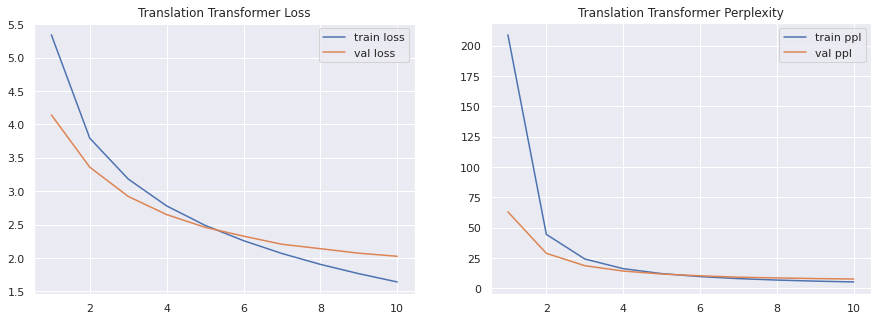

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, NUM_EPOCHS+1), train_losses, label='train loss')
axs[0].plot(range(1, NUM_EPOCHS+1), val_losses, label='val loss')
axs[0].title.set_text('Translation Transformer Loss')
axs[0].legend()

axs[1].plot(range(1, NUM_EPOCHS+1), train_ppls, label='train ppl')
axs[1].plot(range(1, NUM_EPOCHS+1), val_ppls, label='val ppl')
axs[1].title.set_text('Translation Transformer Perplexity')
axs[1].legend()

plt.show()

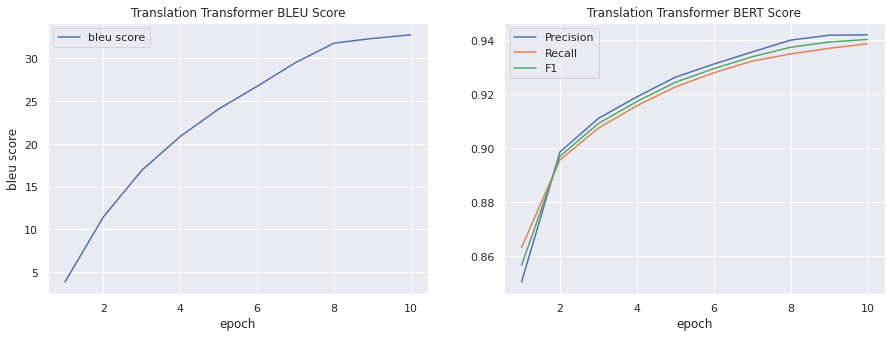

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, NUM_EPOCHS+1), bleu_scores, label='bleu score')
axs[0].title.set_text('Translation Transformer BLEU Score')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('bleu score')
axs[0].legend()


axs[1].plot(range(1, NUM_EPOCHS+1), [bs[0] for bs in bert_scores], label='Precision')
axs[1].plot(range(1, NUM_EPOCHS+1), [bs[1] for bs in bert_scores], label='Recall')
axs[1].plot(range(1, NUM_EPOCHS+1), [bs[2] for bs in bert_scores], label='F1')
axs[1].title.set_text('Translation Transformer BERT Score')
axs[1].set_xlabel('epoch')
axs[1].legend()

plt.show()

In [ ]:
_, trgs, pred_trgs = calculate_bleu_score(transformer, debug=True)

  0%|          | 0/1014 [00:00<?, ?it/s]

In [149]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people stand in front of an outdoor airport . 


In [ ]:
with open('hyps.txt', 'w') as f:
    f.write("\n".join(" ".join(x) for x in pred_trgs))

with open('refs.txt', 'w') as f:
    f.write("\n".join(" ".join(x[0]) for x in trgs))

In [ ]:
! cat hyps.txt | head -10

A group of men are pouring out of a truck .
A man sleeping on a couch in a green room .
A boy with headphones on his shoulders sitting on a woman .
Two men building a blue mat while on a lake .
A shirtless man wearing a red life jacket is wearing a small life jacket .
A woman in a red coat , holding a break from an inflatable striped purse in a blue outfit is jumping for a telescope in the air .
A brown dog runs after the black dog .
A little boy with a football - hair swings a baseball ball towards an ball .
A man is talking on a laptop in a lab office .
A smiling woman with a tan tank top is holding a mountain bike .


In [ ]:
! cat refs.txt | head -10

A group of men are loading cotton onto a truck
A man sleeping in a green room on a couch .
A boy wearing headphones sits on a woman 's shoulders .
Two men setting up a blue ice fishing hut on an iced over lake
A balding man wearing a red life jacket is sitting in a small boat .
A lady in a red coat , holding a bluish hand bag likely of asian descent , jumping off the ground for a snapshot .
A brown dog is running after the black dog .
A young boy wearing a Giants jersey swings a baseball bat at an incoming pitch .
A man in a cluttered office is using the telephone
A smiling woman in a peach tank top stands holding a mountain bike


## BERT Score

In [ ]:
! bert-score -r refs.txt -c hyps.txt --lang en

Downloading: 100% 482/482 [00:00<00:00, 488kB/s]
Downloading: 100% 899k/899k [00:00<00:00, 4.41MB/s]
Downloading: 100% 456k/456k [00:00<00:00, 2.62MB/s]
Downloading: 100% 1.36M/1.36M [00:00<00:00, 5.02MB/s]
Downloading: 100% 1.43G/1.43G [00:23<00:00, 59.6MB/s]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
roberta-large_L17_no-idf_version=0.

`roberta-large_L17_no-idf_version=0.3.9(hug_trans=4.8.2) P: 0.940923 R: 0.940774 F1: 0.940776`

In [ ]:
! bert-score-show --lang en -r "$(head -n 1 refs.txt)" -c "$(head -n 1 hyps.txt)" -f out.png

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2021-07-10 19:34:12.721461: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Saved figure to file:  out.png
<Figure size 1000x1100 with 2 Axes>


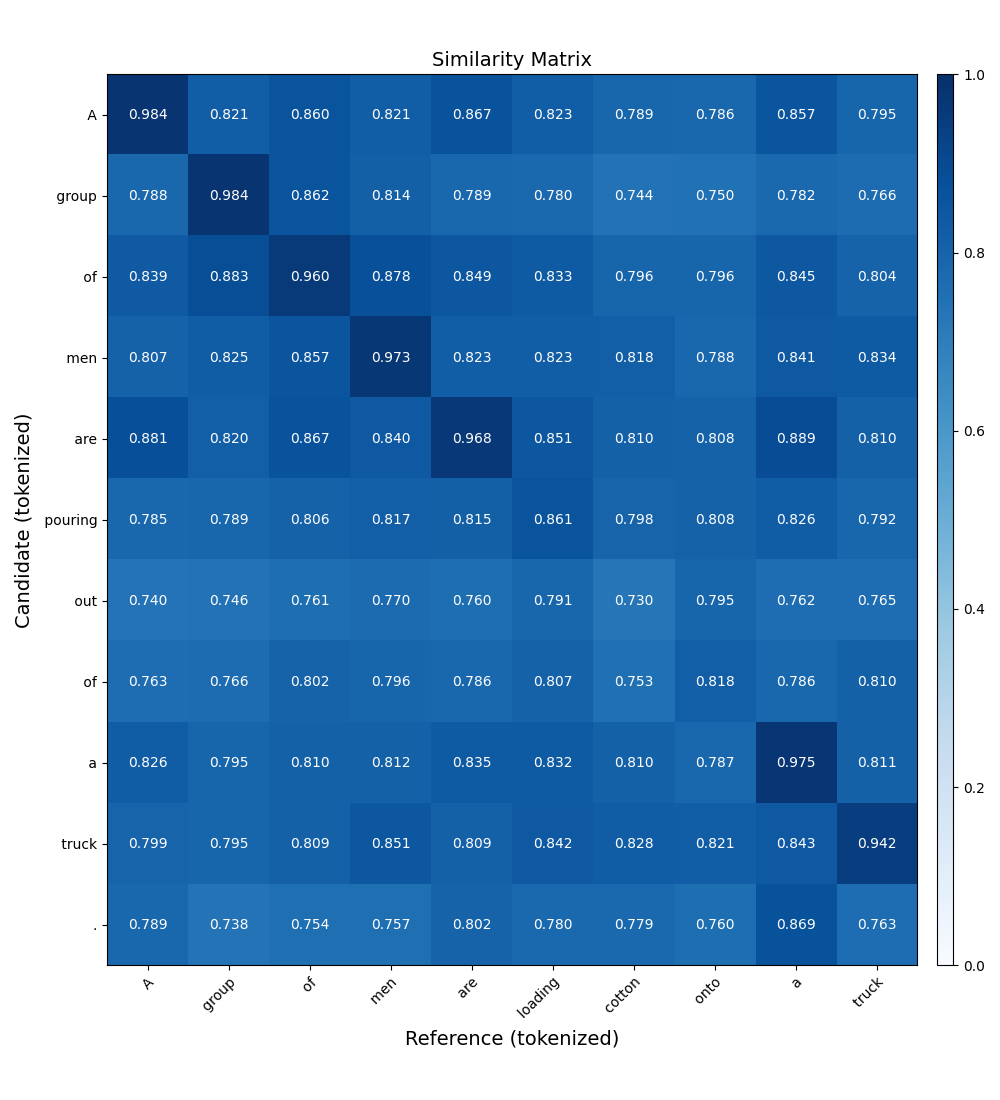

In [ ]:
from PIL import Image

Image.open('out.png')

In [116]:
with open('hyps.txt') as f:
    cands = [line.strip() for line in f]

refs = []
with open('refs.txt') as f:
    curr_ref = [line.strip() for line in f]
    refs.append(curr_ref)

refs = list(zip(*refs))

In [118]:
refs

[('A group of men are loading cotton onto a truck',),
 ('A man sleeping in a green room on a couch .',),
 ("A boy wearing headphones sits on a woman 's shoulders .",),
 ('Two men setting up a blue ice fishing hut on an iced over lake',),
 ('A balding man wearing a red life jacket is sitting in a small boat .',),
 ('A lady in a red coat , holding a bluish hand bag likely of asian descent , jumping off the ground for a snapshot .',),
 ('A brown dog is running after the black dog .',),
 ('A young boy wearing a Giants jersey swings a baseball bat at an incoming pitch .',),
 ('A man in a cluttered office is using the telephone',),
 ('A smiling woman in a peach tank top stands holding a mountain bike',),
 ('A young child is standing alone on some jagged rocks .',),
 ('A person on a snowmobile in mid jump .',),
 ('Three young children stand around a blue and white barrel .',),
 ('A woman is sitting by her dried flower display at an outside market .',),
 ('A female playing a song on her violin

In [ ]:
P, R, F1 = calculate_bert_score(cands_file='hyps.txt', refs_file='refs.txt')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f' ===== BERTScore ====> Precision = {P:.8f}, Recall = {R:.8f}, F1 = {F1:.8f}')

 ===== BERTScore ====> Precision = 0.94092315, Recall = 0.94077426, F1 = 0.94077557


References
----------

1. Attention is all you need paper.
   https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
2. The annotated transformer. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

